In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import io
import zipfile

#https://drive.google.com/open?id=1mDLM4PlKB5ny5ZkXKwMU5IxEpm5kdFgf
file_id="1bnoNMgRwVOeC4z0c9ltYfsQhuFsgH1UP"
downloaded=drive.CreateFile({'id':file_id})
downloaded.GetContentFile('AI.zip')
!unzip AI.zip

Archive:  AI.zip
   creating: AI/test/
   creating: AI/test/cabbage/
  inflating: AI/test/cabbage/75.napa - Copy.jpg  
  inflating: AI/test/cabbage/75.napa.jpg  
  inflating: AI/test/cabbage/76.green-cabbage-png-clip-art - Copy.jpg  
  inflating: AI/test/cabbage/76.green-cabbage-png-clip-art.jpg  
  inflating: AI/test/cabbage/76.kohl-1128482__340 - Copy.jpg  
  inflating: AI/test/cabbage/76.kohl-1128482__340.jpg  
  inflating: AI/test/cabbage/77.269-2699365_cabbage-clipart-cabbage-plant-png-download - Copy.jpg  
  inflating: AI/test/cabbage/77.269-2699365_cabbage-clipart-cabbage-plant-png-download.jpg  
  inflating: AI/test/cabbage/77.36657-1-cabbage - Copy.jpg  
  inflating: AI/test/cabbage/77.36657-1-cabbage.jpg  
  inflating: AI/test/cabbage/78.brassicas_11_2601411724 - Copy.jpg  
  inflating: AI/test/cabbage/78.brassicas_11_2601411724.jpg  
  inflating: AI/test/cabbage/79.Fig-57-Effect-of-different-selected-fungicide-recommended-dose-on-cabbage-leaf-spot - Copy.jpg  
  inflating: A

# New Section

In [ ]:
ls

adc.json  AI/  AI.zip  sample_data/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
!mkdir VGG16

In [ ]:
!mkdir VGG16/logs

In [ ]:
!mkdir VGG16/models

In [ ]:
!touch VGG16/logs/output.log

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt

import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from keras.utils import to_categorical
from keras.optimizers import SGD, RMSprop, adadelta, Adam

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, CSVLogger

Using TensorFlow backend.


In [ ]:
img_rows = 128
img_cols = 128
num_channels = 3
epochs = 5
num_classes = 3
NAME = "vgg16_custom_epoch_" + str(epochs)

In [ ]:
from keras.applications import vgg16

In [ ]:
input_layer = Input(shape=(img_rows, img_cols, num_channels))

In [ ]:
vgg_model = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=input_layer)



58892288/58889256 [==============================] - 1s 0us/step








In [ ]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [ ]:
for i in range(4):
  vgg_model.layers.pop()

In [ ]:
for layer in vgg_model.layers:
  layer.trainable = False

In [ ]:
last_layer = vgg_model.get_layer('block4_pool').output

In [ ]:
conv_1 = Conv2D(64, (3, 3), strides=(1, 1), activation='relu')(last_layer)
conv_2 = Conv2D(64, (3, 3), strides=(1, 1), activation='relu')(conv_1)
conv_3 = Conv2D(32, (3, 3), strides=(1, 1), activation='relu')(conv_2)

flatten = Flatten()(conv_3)

dense_1 = Dense(512, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(dense_1)

output = Dense(num_classes, activation='softmax', name='output')(dense_2)

custom_vgg_model = Model(input_layer, output)
custom_vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        shear_range=0.4,
        zoom_range=0.5,
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        # randomly rotate images in the range (degrees, 0 to 180)
        rotation_range=180,
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.4,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

test_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        shear_range=0.4,
        zoom_range=0.5,
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        # randomly rotate images in the range (degrees, 0 to 180)
        rotation_range=180,
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.4,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

train_generator = train_datagen.flow_from_directory(
        'AI/train',
        target_size=(img_rows, img_cols),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True,)

test_generator = test_datagen.flow_from_directory(
        'AI/test',
        target_size=(img_rows, img_cols),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True,)

Found 572 images belonging to 3 classes.
Found 109 images belonging to 3 classes.


In [ ]:
tensorboard = TensorBoard(log_dir = 'VGG16/logs/' + NAME)

In [ ]:
csv_logger = CSVLogger('VGG16/logs/output.log')

In [ ]:
augmented_checkpoint = ModelCheckpoint('VGG16/models/augmented_best_model.hdf5',  # model filename
                                       monitor='val_loss',  # quantity to monitor
                                       verbose=1,  # verbosity - 0 or 1
                                       save_best_only=True,  # The latest best model will not be overwritten
                                       mode='auto')  # The decision to overwrite model is made automatically depending on the quantity to monitor

In [ ]:
custom_vgg_model.compile(loss=keras.losses.categorical_crossentropy,  # Better loss function for neural networks
              optimizer=Adam(),  # Adam optimizer
              metrics=['accuracy'])  # Metrics to be evaluated by the model

In [ ]:
history = custom_vgg_model.fit_generator(generator=train_generator,
                    validation_data=test_generator,
                    epochs=epochs,
                    callbacks=[augmented_checkpoint, tensorboard, csv_logger],
                    verbose=1,
                    steps_per_epoch=1024,
                    validation_steps=64,
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Epoch 1/5


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


1024/1024 [==============================] - 581s 567ms/step - loss: 0.2804 - acc: 0.8917 - val_loss: 0.4636 - val_acc: 0.8372

Epoch 00001: val_loss improved from inf to 0.46364, saving model to VGG16/models/augmented_best_model.hdf5

Epoch 2/5
1024/1024 [==============================] - 582s 569ms/step - loss: 0.1310 - acc: 0.9542 - val_loss: 0.6031 - val_acc: 0.8486

Epoch 00002: val_loss did not improve from 0.46364
Epoch 3/5
1024/1024 [==============================] - 592s 578ms/step - loss: 0.0951 - acc: 0.9678 - val_loss: 0.7089 - val_acc: 0.8291

Epoch 00003: val_loss did not improve from 0.46364
Epoch 4/5
1024/1024 [==============================] - 590s 576ms/step - loss: 0.0798 - acc: 0.9726 - val_loss: 0.6006 - val_acc: 0.8412

Epoch 00004: val_loss did not improve from 0.46364
Epoch 5/5
 462/1024 [============>.................] - ETA: 5:13 - loss: 0.0703 - acc: 0.9747

In [ ]:
# serialize model to JSON
model_json = custom_vgg_model.to_json()
with open("VGG16/models/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
custom_vgg_model.save_weights("VGG16/models/model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
32

In [ ]:
%matplotlib inline

import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
from keras import models
from keras.preprocessing import image

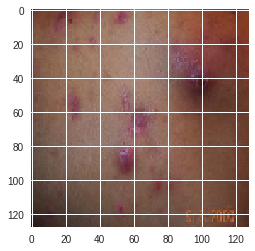

In [ ]:
img_path = 'skindis_data/test/acne/Acne affecting the back32.jpg'

img = image.load_img(img_path, target_size=(img_rows, img_cols))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

In [ ]:
layer_outputs = [layer.output for layer in custom_vgg_model.layers[1:-4]] # Extracts the outputs of all layers
activation_model = models.Model(inputs=custom_vgg_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [ ]:
activations = activation_model.predict(img_tensor) # Returns a list of five Numpy arrays: one array per layer activation

In [ ]:

first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 128, 128, 64)


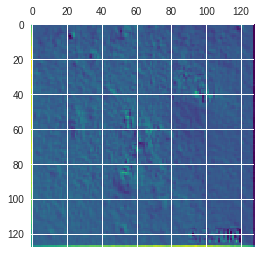

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

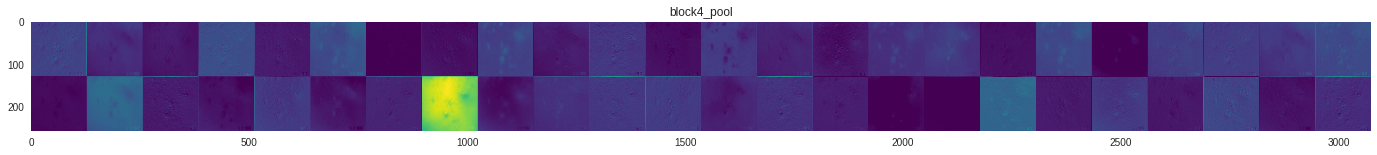

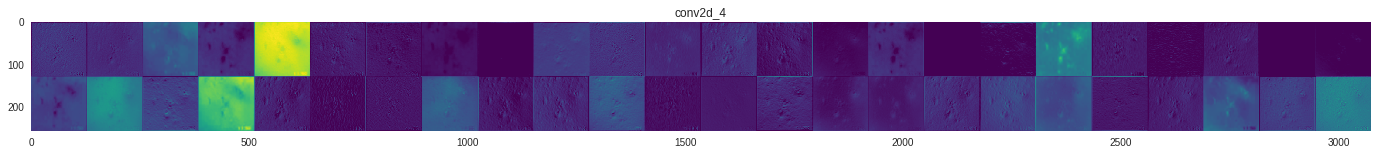

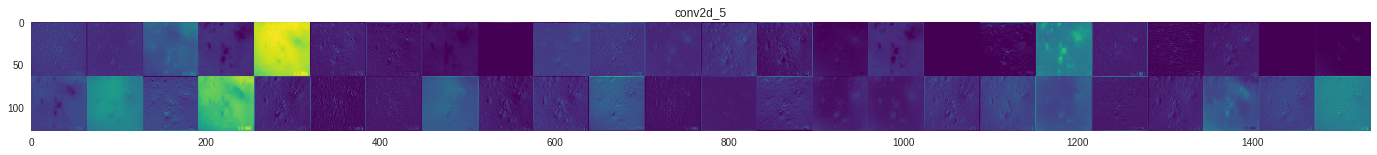

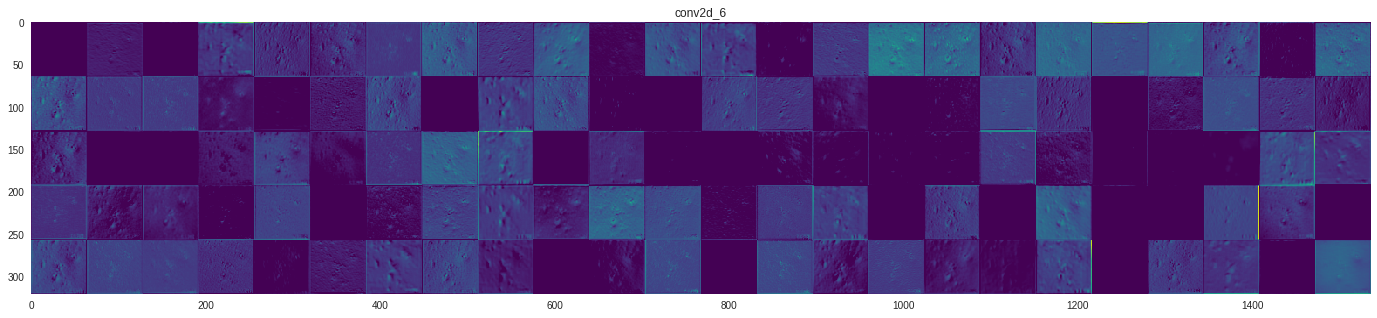

In [ ]:
layer_names = []
for layer in custom_vgg_model.layers[-8:-4]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 24

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            #channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            #channel_image /= channel_image.std()
            #channel_image *= 64
            #channel_image += 128
            #channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [ ]:
from bson import json_util
import datetime
import pytz
import math
from keras.models import model_from_json
import tensorflow as tf
import cv2
import numpy as np

global model, graph, label_dictionary

label_dictionary = {0: 'acne', 1: 'eczema', 2: 'psoriasis',3: 'vitiligo'}

json_file = open('VGG16/models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("VGG16/models/model.h5")

graph = tf.get_default_graph()

In [ ]:
def predict():
    #test = request.files['file-field']
    #print(test)
    #test.save('test.jpg')

    image_path = "skindis_data/test/acne/Acne affecting the back32.jpg"

    img = cv2.imread(image_path)
    output = cv2.resize(img, (256, 256)).copy()
    img = cv2.resize(img, (128, 128))
    img = img / 255
    with graph.as_default():
        proba = model.predict(img.reshape(-1, 128, 128, 3))

    idx = np.argmax(proba)
    label = '<h1>' + label_dictionary[idx] + " ====> " + str(np.max(proba) * 100)[:5] + "%" + '</h1>'
    return label
predict()

'<h1>acne ====> 99.99%</h1>'

In [ ]:
def predict():
    #test = request.files['file-field']
    #print(test)
    #test.save('test.jpg')

    image_path = "skindis_data/test/psoriasis/Psoriasis affecting the face4084.jpg"

    img = cv2.imread(image_path)
    output = cv2.resize(img, (256, 256)).copy()
    img = cv2.resize(img, (128, 128))
    img = img / 255
    with graph.as_default():
        proba = model.predict(img.reshape(-1, 128, 128, 3))

    idx = np.argmax(proba)
    label = '<h1>' + label_dictionary[idx] + " ====> " + str(np.max(proba) * 100)[:5] + "%" + '</h1>'
    return label
predict()

'<h1>psoriasis ====> 98.94%</h1>'